## Для начала посмотрим на наши данные, нужно понять с чем мы работаем

### Подключим все необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, mean_absolute_error
from collections import Counter
import re
import nltk
#import pymorphy2
from ast import literal_eval
import gensim
import math


### Поля данных

* warehouse_id - идентификатор магазина
* product_id - идентификатор продукта
* date - дата
* quantity - кол-во продаж
* id - уникальный идентификатор строки

 

In [2]:
train_data = pd.read_csv("../input/grocery-sales-forecast/train.csv")
print(train_data.shape)
train_data.head(16)

(78067, 5)


,warehouse_id,product_id,date,quantity,id
0,0,71165,2020-12-02,1,0
1,0,71165,2020-12-03,3,1
2,0,71165,2020-12-07,2,2
3,0,71165,2020-12-08,2,3
4,0,71165,2020-12-09,3,4
5,0,71165,2020-12-10,1,5
6,0,71165,2020-12-12,6,6
7,0,71165,2020-12-13,4,7
8,0,71165,2020-12-14,4,8
9,0,71165,2020-12-15,9,9


### Посмотрим на количество товаров и на их id

In [3]:
product_id = train_data.sort_values(by=['product_id'])['product_id'].unique()
print(len(product_id))
print(product_id[:5])

3288
[71165 71170 71185 71215 71220]


### Посмотрим на тестовую выборку и сделаем некоторые выводы

In [4]:
test_data = pd.read_csv("../input/grocery-sales-forecast/test.csv")
print(test_data.shape)
test_data.head(15)

(46032, 4)


,date,product_id,warehouse_id,id
0,2021-04-09,71165,0,0
1,2021-04-09,71165,1,1
2,2021-04-09,71170,0,2
3,2021-04-09,71170,1,3
4,2021-04-09,71185,0,4
5,2021-04-09,71185,1,5
6,2021-04-09,71215,0,6
7,2021-04-09,71215,1,7
8,2021-04-09,71220,0,8
9,2021-04-09,71220,1,9


### Сразу хочется посмотреть на warehouse_id и на product_id, так как при разных product_id будут проблемы


In [5]:
product_test_id = test_data.sort_values(by=['product_id'])['product_id'].unique()
print(len(product_test_id))
print(product_test_id[:5])
print(len(set(product_test_id == product_id)))  # Все значения совпадают, проблем нет

3288
[71165 71170 71185 71215 71220]
1


In [6]:
warehouse_id = test_data['warehouse_id'].unique()
print(len(warehouse_id))  # Всего два магазина

2


### В нашем случае всего два магазина и все значения id товаров совпадают. Проблем с данными нет.

### Посмотрим на simple submission

In [7]:
simple_data = pd.read_csv("../input/grocery-sales-forecast/sub.csv")
print(simple_data.shape)
simple_data.head()

(46032, 2)


,id,quantity
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


## Разделение данных на train / test

### Итак, суть задачи ясна. Проблем пока не обнаружено, поэтому разделяем нашу train выборку и начинаем реализовывать идеи

In [8]:
'''
# Это плохой способ разделять данные в нашем случае!
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('quantity', axis=1), train_data[['quantity']], test_size=0.1945, random_state=42)
print(X_train.head(3))
print(X_test.head(3))
print(y_train.head(3))
print(y_test.head(3))
'''

"\n# Это плохой способ разделять данные в нашем случае!\nX_train, X_test, y_train, y_test = train_test_split(train_data.drop('quantity', axis=1), train_data[['quantity']], test_size=0.1945, random_state=42)\nprint(X_train.head(3))\nprint(X_test.head(3))\nprint(y_train.head(3))\nprint(y_test.head(3))\n"

### Необходимо понимать, что в данных есть пропуски. Это видно по X_train

In [9]:
train_data = train_data.sort_values(by=['date', 'product_id'])
X_train = train_data.drop('quantity', axis=1)
y_train = train_data['quantity']
X_train

,warehouse_id,product_id,date,id
181,0,71220,2020-11-27,191
30017,1,71220,2020-11-27,32102
30551,1,71455,2020-11-27,32660
30772,1,71575,2020-11-27,32892
30796,1,71580,2020-11-27,32917
...,...,...,...,...
78058,1,98240,2021-04-08,83117
78061,1,98250,2021-04-08,83131
29790,0,98255,2021-04-08,31817
78065,1,98620,2021-04-08,83150


### Таким образом имеем отсортированные по дате и id данные. Идея деления:

*   Находим границу последних n дней
*   Делим на train / test по этой границе



In [10]:
# n = 5  # 2021-04-08 - 5 = 2021-04-03 -- Граница
X_train = train_data.where(train_data['date'] < '2021-04-03').dropna().drop('quantity', axis=1)
y_train = train_data.where(train_data['date'] < '2021-04-03').dropna()['quantity']
X_test = train_data.where(train_data['date'] >= '2021-04-03').dropna().drop('quantity', axis=1)
y_test = train_data.where(train_data['date'] >= '2021-04-03').dropna()['quantity']
print(X_train.head(3))
print(X_test.head(3))
print(y_train.head(3))
print(y_test.head(3))

       warehouse_id  product_id        date       id
181             0.0     71220.0  2020-11-27    191.0
30017           1.0     71220.0  2020-11-27  32102.0
30551           1.0     71455.0  2020-11-27  32660.0
       warehouse_id  product_id        date       id
92              0.0     71165.0  2021-04-03     92.0
29894           1.0     71165.0  2021-04-03  31961.0
179             0.0     71215.0  2021-04-03    186.0
181      1.0
30017    1.0
30551    1.0
Name: quantity, dtype: float64
92       7.0
29894    3.0
179      1.0
Name: quantity, dtype: float64


## Первая идея: дни недели

### Суть идеи заключается в том, чтобы в каждом магазине найти некие зависимости в соотношении проданный товар/день недели, далее на основе этих зависимостей седлать прогноз



---





### Для начала создадим словарь: дата - день недели

In [11]:
data_ = pd.Series(pd.to_datetime(train_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(train_data['date'].unique(), data_week))
print(date2week)

{'2020-11-27': 'Friday', '2020-11-28': 'Saturday', '2020-11-29': 'Sunday', '2020-11-30': 'Monday', '2020-12-01': 'Tuesday', '2020-12-02': 'Wednesday', '2020-12-03': 'Thursday', '2020-12-04': 'Friday', '2020-12-05': 'Saturday', '2020-12-06': 'Sunday', '2020-12-07': 'Monday', '2020-12-08': 'Tuesday', '2020-12-09': 'Wednesday', '2020-12-10': 'Thursday', '2020-12-11': 'Friday', '2020-12-12': 'Saturday', '2020-12-13': 'Sunday', '2020-12-14': 'Monday', '2020-12-15': 'Tuesday', '2020-12-16': 'Wednesday', '2020-12-17': 'Thursday', '2020-12-18': 'Friday', '2020-12-19': 'Saturday', '2020-12-20': 'Sunday', '2020-12-21': 'Monday', '2020-12-22': 'Tuesday', '2020-12-23': 'Wednesday', '2020-12-24': 'Thursday', '2020-12-25': 'Friday', '2020-12-26': 'Saturday', '2020-12-27': 'Sunday', '2020-12-28': 'Monday', '2020-12-29': 'Tuesday', '2020-12-30': 'Wednesday', '2020-12-31': 'Thursday', '2021-01-01': 'Friday', '2021-01-02': 'Saturday', '2021-01-03': 'Sunday', '2021-01-04': 'Monday', '2021-01-05': 'Tuesda

### Далее создадим словарь, где key = warehouse_id + product_id, а value = новый словарь с key = день недели и value = массив числа продаж

In [12]:
my_dict = {}
# k = 0
for product_info, product_quantity in tqdm(zip(X_train[['warehouse_id', 'product_id', 'date']].values, y_train)):
    '''
    product_info[0] - warehouse_id - идентификатор магазина
    product_info[1] - product_id - идентификатор продукта
    product_info[2] - date - дата
    product_quantity - quantity - кол-во продаж
    '''
    my_id = str(product_info[0]) + str(product_info[1])
    # print(my_id, product_info[0], product_info[1])
    if my_id in my_dict:
        if date2week[product_info[2]] in my_dict[my_id]:
            my_dict[my_id][date2week[product_info[2]]].append(product_quantity)
        else:
             my_dict[my_id][date2week[product_info[2]]] = [product_quantity]
    else:
        my_dict[my_id] = {}
        my_dict[my_id][date2week[product_info[2]]] = [product_quantity]
# my_dict

73665it [00:00, 223637.07it/s]


### Теперь для тестовой выборки будем смотреть в этот словарь и искать ответ в зависимости от данных словаря

In [13]:
answer_round, answer_floor, answer_ceil = [], [], []
nice_product, bad_product = 0, 0
for product_info in tqdm(X_test[['warehouse_id', 'product_id', 'date']].values):
    my_id_first = str(product_info[0]) + str(product_info[1])
    my_id_second = date2week[product_info[2]]
    try:
        my_array = my_dict[my_id_first][my_id_second]  # Если данных нет в словаре 
        nice_product += 1
    except:
        bad_product += 1
        my_array = []
    if len(my_array) < 1:
        answer_round.append(1)
        answer_floor.append(1)
        answer_ceil.append(1)
    else:  # Попробуем среднее
        answer_round.append(round(sum(my_array) / len(my_array)))
        answer_floor.append(math.floor(sum(my_array) / len(my_array)))
        answer_ceil.append(math.ceil(sum(my_array) / len(my_array)))
print()
print(nice_product, bad_product)
# print(len(answer), len(y_test))
print(mean_absolute_error(y_test, answer_round))
print(mean_absolute_error(y_test, answer_floor))
print(mean_absolute_error(y_test, answer_ceil))

100%|██████████| 4402/4402 [00:00<00:00, 171364.51it/s]



3550 852
0.7716946842344389
0.726715129486597
0.8555202180826896


### Показывает достаточно неплохой результат. Причём округление в большую сторону даёт лучший результат. Его и буду использовать. 

In [14]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

{'2021-04-09': 'Friday', '2021-04-10': 'Saturday', '2021-04-11': 'Sunday', '2021-04-12': 'Monday', '2021-04-13': 'Tuesday', '2021-04-14': 'Wednesday', '2021-04-15': 'Thursday'}


In [15]:
answer_ceil = []
nice_product, bad_product = 0, 0
data_2 = pd.Series(pd.to_datetime(test_data['date'].unique()))
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    #print()
    #print(product_info)
    #break
    my_id_first = str(float(product_info[0])) + str(float(product_info[1]))
    my_id_second = date2week[product_info[2]]
    try:
        my_array = my_dict[my_id_first][my_id_second]  # Если данных нет в словаре 
        nice_product += 1
    except:
        bad_product += 1
        my_array = []
    if len(my_array) < 3:  # Если товар в определённый день недели купили пару раз, то логично предположить, что его не купят вовсе
        answer_ceil.append(0)

    else:  
        answer_ceil.append(math.ceil(sum(my_array) / len(my_array)))
print()
print(nice_product, bad_product)
print(len(answer_ceil), len(simple_data))


100%|██████████| 46032/46032 [00:00<00:00, 271203.48it/s]


25975 20057
46032 46032


In [16]:
#Result_table = pd.read_csv("/content/drive/MyDrive/Sales_Forecasting/sub.csv")
#Result_table['quantity'] = pd.Series(answer_ceil)
#Result_table[["id", "quantity"]].to_csv("FINAL.csv", index=False)

### Score = 0.46886 
### Мягко говоря - ужасно...


## Выводы после первой идеи:

* Корявая обработка нулей, нужно исправлять
* На основе количества продаж в определённые дни нужно пытаться делать что-то более нетривиальное, чем просто среднее
* Необходимо изменить test / train выборку, ибо нет учёта нулей



### Начнём исправляться с заполнения нашей выборки нулями
Идея такая: если в определённый день информации о товаре нет, то значит его купили 0 раз. Это поле должно храниться в выборке.

In [17]:
product_id = train_data['product_id'].unique()
date = train_data['date'].unique()
warehouse_id = train_data['warehouse_id'].unique()
print(len(product_id), len(date), len(warehouse_id), len(product_id) * len(date) * len(warehouse_id))

3288 133 2 874608


### Значит у нас должно быть 874608 записей. Не будем вставлять недостоющие записи в таблицу, а сразу будем составлять словарик. Он будет таким же, но более разряженее.

In [18]:
my_current_dict = {}
for product_info in tqdm(train_data[['warehouse_id', 'product_id', 'date', 'quantity']].values):
    '''
    product_info[0] - warehouse_id - идентификатор магазина
    product_info[1] - product_id - идентификатор продукта
    product_info[2] - date - дата
    product_info[3] - quantity - кол-во продаж
    '''
    my_id = str(product_info[0]) + str(product_info[1]) + str(product_info[2])
    my_current_dict[my_id] = product_info[3]
print()
print(len(my_current_dict))

100%|██████████| 78067/78067 [00:00<00:00, 498202.67it/s]


78067


### Информация есть менее чем о 10% товаров.

In [19]:
data_ = pd.Series(pd.to_datetime(train_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(train_data['date'].unique(), data_week))
print(date2week)

{'2020-11-27': 'Friday', '2020-11-28': 'Saturday', '2020-11-29': 'Sunday', '2020-11-30': 'Monday', '2020-12-01': 'Tuesday', '2020-12-02': 'Wednesday', '2020-12-03': 'Thursday', '2020-12-04': 'Friday', '2020-12-05': 'Saturday', '2020-12-06': 'Sunday', '2020-12-07': 'Monday', '2020-12-08': 'Tuesday', '2020-12-09': 'Wednesday', '2020-12-10': 'Thursday', '2020-12-11': 'Friday', '2020-12-12': 'Saturday', '2020-12-13': 'Sunday', '2020-12-14': 'Monday', '2020-12-15': 'Tuesday', '2020-12-16': 'Wednesday', '2020-12-17': 'Thursday', '2020-12-18': 'Friday', '2020-12-19': 'Saturday', '2020-12-20': 'Sunday', '2020-12-21': 'Monday', '2020-12-22': 'Tuesday', '2020-12-23': 'Wednesday', '2020-12-24': 'Thursday', '2020-12-25': 'Friday', '2020-12-26': 'Saturday', '2020-12-27': 'Sunday', '2020-12-28': 'Monday', '2020-12-29': 'Tuesday', '2020-12-30': 'Wednesday', '2020-12-31': 'Thursday', '2021-01-01': 'Friday', '2021-01-02': 'Saturday', '2021-01-03': 'Sunday', '2021-01-04': 'Monday', '2021-01-05': 'Tuesda

In [20]:
my_huge_dict = {}
nice_product = 0
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            my_id = str(id_warehouse) + str(id_product) + str(id_date)
            if my_id in my_current_dict:
                nice_product += 1
                if id_warehouse in my_huge_dict:
                    if id_product in my_huge_dict[id_warehouse]:
                        if date2week[id_date] in my_huge_dict[id_warehouse][id_product]:
                            my_huge_dict[id_warehouse][id_product][date2week[id_date]].append(my_current_dict[my_id])
                        else:
                            my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                    else:
                        my_huge_dict[id_warehouse][id_product] = {}
                        my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                else:
                    my_huge_dict[id_warehouse] = {}
                    my_huge_dict[id_warehouse][id_product] = {}
                    my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
            else:
                if id_warehouse in my_huge_dict:
                    if id_product in my_huge_dict[id_warehouse]:
                        if date2week[id_date] in my_huge_dict[id_warehouse][id_product]:
                            my_huge_dict[id_warehouse][id_product][date2week[id_date]].append(0)
                        else:
                            my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [0]
                    else:
                        my_huge_dict[id_warehouse][id_product] = {}
                        my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [0]
                else:
                    my_huge_dict[id_warehouse] = {}
                    my_huge_dict[id_warehouse][id_product] = {}
                    my_huge_dict[id_warehouse][id_product][date2week[id_date]] = [0]
print()
print(nice_product)

100%|██████████| 3288/3288 [00:01<00:00, 2421.76it/s]


78067


### Проверим себя

In [21]:
amount = 0
set_amount = set()
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            if str(id_warehouse) + str(id_product) + str(date2week[id_date]) not in set_amount:
                amount += len(my_huge_dict[id_warehouse][id_product][date2week[id_date]])
                set_amount.add(str(id_warehouse) + str(id_product) + str(date2week[id_date]))
print()
print(amount)

100%|██████████| 3288/3288 [00:00<00:00, 3700.02it/s]


874608


### Размеры совпадают, теперь можно делить на train / test. За границу возьмём 2021-04-01, ровно 7 дней

In [22]:
# Понимаю, что проделываю такую же работу, что и пару ячеек выше. Но хочу сделать акцент на понимании кода
my_huge_dict_train = {}
my_huge_dict_test = {}
nice_product = 0
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            if id_date > '2021-04-01':
                my_id = str(id_warehouse) + str(id_product) + str(id_date)
                if my_id in my_current_dict:
                    nice_product += 1
                    if id_warehouse in my_huge_dict_test:
                        if id_product in my_huge_dict_test[id_warehouse]:
                            if date2week[id_date] in my_huge_dict_test[id_warehouse][id_product]:
                                my_huge_dict_test[id_warehouse][id_product][date2week[id_date]].append(my_current_dict[my_id])
                            else:
                                my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                        else:
                            my_huge_dict_test[id_warehouse][id_product] = {}
                            my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                    else:
                        my_huge_dict_test[id_warehouse] = {}
                        my_huge_dict_test[id_warehouse][id_product] = {}
                        my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                else:
                    if id_warehouse in my_huge_dict_test:
                        if id_product in my_huge_dict_test[id_warehouse]:
                            if date2week[id_date] in my_huge_dict_test[id_warehouse][id_product]:
                                my_huge_dict_test[id_warehouse][id_product][date2week[id_date]].append(0)
                            else:
                                my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [0]
                        else:
                            my_huge_dict_test[id_warehouse][id_product] = {}
                            my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [0]
                    else:
                        my_huge_dict_test[id_warehouse] = {}
                        my_huge_dict_test[id_warehouse][id_product] = {}
                        my_huge_dict_test[id_warehouse][id_product][date2week[id_date]] = [0]
            else:
                my_id = str(id_warehouse) + str(id_product) + str(id_date)
                if my_id in my_current_dict:
                    nice_product += 1
                    if id_warehouse in my_huge_dict_train:
                        if id_product in my_huge_dict_train[id_warehouse]:
                            if date2week[id_date] in my_huge_dict_train[id_warehouse][id_product]:
                                my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].append(my_current_dict[my_id])
                            else:
                                my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                        else:
                            my_huge_dict_train[id_warehouse][id_product] = {}
                            my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                    else:
                        my_huge_dict_train[id_warehouse] = {}
                        my_huge_dict_train[id_warehouse][id_product] = {}
                        my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [my_current_dict[my_id]]
                else:
                    if id_warehouse in my_huge_dict_train:
                        if id_product in my_huge_dict_train[id_warehouse]:
                            if date2week[id_date] in my_huge_dict_train[id_warehouse][id_product]:
                                my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].append(0)
                            else:
                                my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [0]
                        else:
                            my_huge_dict_train[id_warehouse][id_product] = {}
                            my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [0]
                    else:
                        my_huge_dict_train[id_warehouse] = {}
                        my_huge_dict_train[id_warehouse][id_product] = {}
                        my_huge_dict_train[id_warehouse][id_product][date2week[id_date]] = [0]
print()
print(nice_product)

100%|██████████| 3288/3288 [00:01<00:00, 2410.82it/s]


78067


In [23]:
amount = 0
set_amount = set()
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            if str(id_warehouse) + str(id_product) + str(date2week[id_date]) not in set_amount:
                amount += len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])
                set_amount.add(str(id_warehouse) + str(id_product) + str(date2week[id_date]))
print()
print(amount)

100%|██████████| 3288/3288 [00:00<00:00, 3540.39it/s]


828576


In [24]:
amount = 0
set_amount = set()
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            if str(id_warehouse) + str(id_product) + str(date2week[id_date]) not in set_amount:
                amount += 1  # len(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]])  # Работает, так как у нас всегда массив из одного числа
                set_amount.add(str(id_warehouse) + str(id_product) + str(date2week[id_date]))
print()
print(amount)

100%|██████████| 3288/3288 [00:00<00:00, 3686.85it/s]


46032


### Тестовая выборка занимает всего 5%. Это нужно будет учитывать!

In [25]:
right_answer = []
answer_round, answer_floor, answer_ceil = [], [], []
set_amount = set()
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            answer_round.append(round(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))
            answer_floor.append(math.floor(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))
            answer_ceil.append(math.ceil(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))
print(mean_absolute_error(right_answer, answer_round))
print(mean_absolute_error(right_answer, answer_floor))
print(mean_absolute_error(right_answer, answer_ceil))

100%|██████████| 3288/3288 [00:01<00:00, 1646.54it/s]


0.21154848800834203
0.1989051094890511
0.5856795272853667


### Не будем повторять ошибок. Вместо ceil возьмём floor

In [26]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))


#print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

{'2021-04-09': 'Friday', '2021-04-10': 'Saturday', '2021-04-11': 'Sunday', '2021-04-12': 'Monday', '2021-04-13': 'Tuesday', '2021-04-14': 'Wednesday', '2021-04-15': 'Thursday'}


In [27]:
answer = []
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = (product_info[2])
    #print(id_warehouse)
    #print(id_product)
    #print(id_date)
    #print(my_huge_dict[id_warehouse][id_product][date2week[id_date]])
    #break
    answer.append(math.floor(sum(my_huge_dict[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict[id_warehouse][id_product][date2week[id_date]])))
    
print()
print(len(answer), len(simple_data))


100%|██████████| 46032/46032 [00:00<00:00, 249528.85it/s]


46032 46032


In [28]:
#Result_table = pd.read_csv("/content/drive/MyDrive/Sales_Forecasting/sub.csv")
#Result_table['quantity'] = pd.Series(answer)
#Result_table[["id", "quantity"]].to_csv("FINAL.csv", index=False)

### Score = 0.20210
### Это уже гораздо лучше, но не предел :)

## Вторая идея: модернизация среднего



### Пока оставим идею с днями недели, но будем рассматривать не обычное среднее, а что-то поинтереснее

In [29]:
data_ = pd.Series(pd.to_datetime(train_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(train_data['date'].unique(), data_week))
print(date2week)

{'2020-11-27': 'Friday', '2020-11-28': 'Saturday', '2020-11-29': 'Sunday', '2020-11-30': 'Monday', '2020-12-01': 'Tuesday', '2020-12-02': 'Wednesday', '2020-12-03': 'Thursday', '2020-12-04': 'Friday', '2020-12-05': 'Saturday', '2020-12-06': 'Sunday', '2020-12-07': 'Monday', '2020-12-08': 'Tuesday', '2020-12-09': 'Wednesday', '2020-12-10': 'Thursday', '2020-12-11': 'Friday', '2020-12-12': 'Saturday', '2020-12-13': 'Sunday', '2020-12-14': 'Monday', '2020-12-15': 'Tuesday', '2020-12-16': 'Wednesday', '2020-12-17': 'Thursday', '2020-12-18': 'Friday', '2020-12-19': 'Saturday', '2020-12-20': 'Sunday', '2020-12-21': 'Monday', '2020-12-22': 'Tuesday', '2020-12-23': 'Wednesday', '2020-12-24': 'Thursday', '2020-12-25': 'Friday', '2020-12-26': 'Saturday', '2020-12-27': 'Sunday', '2020-12-28': 'Monday', '2020-12-29': 'Tuesday', '2020-12-30': 'Wednesday', '2020-12-31': 'Thursday', '2021-01-01': 'Friday', '2021-01-02': 'Saturday', '2021-01-03': 'Sunday', '2021-01-04': 'Monday', '2021-01-05': 'Tuesda

In [30]:
import statistics
from scipy import stats as s

right_answer = []
answer_round, answer_floor, answer_ceil = [], [], []
answer_median, answer_median_low, answer_median_high = [], [], []
answer_mode = []
set_amount = set()
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            answer_round.append(round(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))
            answer_floor.append(math.floor(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))
            answer_ceil.append(math.ceil(sum(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])/len(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])))

            answer_median.append(statistics.median(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]]))
            answer_median_low.append(statistics.median_low(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]]))
            answer_median_high.append(statistics.median_high(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]]))
            
            answer_mode.append(int(s.mode(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]])[0]))

print(mean_absolute_error(right_answer, answer_round))
print(mean_absolute_error(right_answer, answer_floor))
print(mean_absolute_error(right_answer, answer_ceil))

print(mean_absolute_error(right_answer, answer_median))
print(mean_absolute_error(right_answer, answer_median_low))
print(mean_absolute_error(right_answer, answer_median_high))

print(mean_absolute_error(right_answer, answer_mode))

100%|██████████| 3288/3288 [01:02<00:00, 52.74it/s]


0.21154848800834203
0.1989051094890511
0.5856795272853667
0.19765597844977406
0.19797097671185263
0.1975147723322906
0.20550921098366354


### Медиана даёт неплохой результат. Но давайте попробуем нечто сложнее


In [31]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [32]:

cur_min = 1
cur_alpha = 0

for i in tqdm(range(1, 30)):
    alpha = i/100
    right_answer = []
    answer_exponential_smoothing_round, answer_exponential_smoothing_floor, answer_exponential_smoothing_ceil = [], [], []
    for id_warehouse in warehouse_id:
        for id_product in (product_id):
            for id_date in date:
                right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
                #answer_exponential_smoothing_round.append(round(exponential_smoothing(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]], alpha)))
                answer_exponential_smoothing_floor.append(math.floor(exponential_smoothing(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]], alpha)))
                #answer_exponential_smoothing_ceil.append(math.ceil(exponential_smoothing(my_huge_dict_train[id_warehouse][id_product][date2week[id_date]], alpha)))
    if mean_absolute_error(right_answer, answer_exponential_smoothing_floor) < cur_min:
        cur_min = mean_absolute_error(right_answer, answer_exponential_smoothing_floor)
        cur_alpha = alpha
#print(mean_absolute_error(right_answer, answer_exponential_smoothing_round))
print(cur_min, cur_alpha)
#print(mean_absolute_error(right_answer, answer_exponential_smoothing_ceil))

100%|██████████| 29/29 [02:25<00:00,  5.02s/it]

0.19703684393465415 0.14


### Сильного прироста нет, поэтому двойное экспонициальное сглаживание использовать не имеет смысла

In [33]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))


#print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

{'2021-04-09': 'Friday', '2021-04-10': 'Saturday', '2021-04-11': 'Sunday', '2021-04-12': 'Monday', '2021-04-13': 'Tuesday', '2021-04-14': 'Wednesday', '2021-04-15': 'Thursday'}


In [34]:
answer = []
alpha = 0.14
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = (product_info[2])
    answer.append(math.floor(exponential_smoothing(my_huge_dict[id_warehouse][id_product][date2week[id_date]], alpha)))
    
print()
print(len(answer), len(simple_data))

100%|██████████| 46032/46032 [00:00<00:00, 127149.59it/s]


46032 46032


In [35]:
#Result_table = pd.read_csv("/content/drive/MyDrive/Sales_Forecasting/sub.csv")
#Result_table['quantity'] = pd.Series(answer)
#Result_table[["id", "quantity"]].to_csv("FINAL_exp.csv", index=False)

### Score = 0.20085
### Сильного роста нет. Нужно что-то сложнее...

## Третья идея: учёт соседних дней


### Хочется делать предсказание не только по всем четвергам для предсказания продаж в четверг, но и как-то учитывать соседние дни. Для этого давайте попробуем визуализировать наши данные.


In [36]:
first_warehouse = {}
second_warehouse = {}
number_of_products = 10
set_of_products = set()

for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = date2week[(product_info[2])]

    if id_product in set_of_products or len(set_of_products) < number_of_products:
        set_of_products.add(id_product)

        if id_warehouse == 0:
            if id_product not in first_warehouse:
                first_warehouse[id_product] = {}
                first_warehouse[id_product][id_date] = my_huge_dict[id_warehouse][id_product][id_date]

            else:
                if id_date not in first_warehouse[id_product]:
                    first_warehouse[id_product][id_date] = my_huge_dict[id_warehouse][id_product][id_date]

        else:
            if id_product not in second_warehouse:
                second_warehouse[id_product] = {}
                second_warehouse[id_product][id_date] = my_huge_dict[id_warehouse][id_product][id_date]

            else:
                if id_date not in second_warehouse[id_product]:
                    second_warehouse[id_product][id_date] = my_huge_dict[id_warehouse][id_product][id_date]
        

    
print()

print(first_warehouse)
print(len(first_warehouse))
print(len(first_warehouse[71165]))

print(second_warehouse)
print(len(second_warehouse))
print(len(second_warehouse[71165]))

100%|██████████| 46032/46032 [00:00<00:00, 838379.98it/s]


{71165: {'Friday': [0, 0, 0, 1, 1, 1, 0, 1, 0, 6, 2, 0, 5, 1, 4, 4, 2, 1, 2], 'Saturday': [0, 0, 6, 0, 2, 2, 0, 6, 5, 6, 2, 1, 1, 1, 0, 6, 1, 2, 7], 'Sunday': [0, 0, 4, 3, 0, 3, 4, 0, 2, 16, 2, 2, 3, 2, 3, 4, 7, 9, 4], 'Monday': [0, 2, 4, 3, 1, 1, 2, 1, 1, 6, 1, 2, 4, 1, 3, 4, 11, 0, 2], 'Tuesday': [0, 2, 9, 1, 2, 2, 0, 0, 1, 1, 6, 0, 3, 4, 1, 1, 2, 0, 6], 'Wednesday': [1, 3, 0, 0, 3, 0, 2, 2, 2, 0, 1, 3, 1, 2, 2, 3, 0, 0, 2], 'Thursday': [3, 1, 0, 3, 5, 3, 0, 1, 5, 0, 2, 2, 0, 0, 2, 4, 0, 0, 0]}, 71170: {'Friday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 5, 0], 'Saturday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 7, 0, 0, 5, 0], 'Sunday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 4, 0, 0, 1, 0], 'Monday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0], 'Tuesday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 0], 'Wednesday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 0, 6, 0, 0], 'Thursday': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 3, 0, 0, 4, 0, 0

Friday
Saturday
Sunday
Monday
Tuesday
Wednesday
Thursday


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


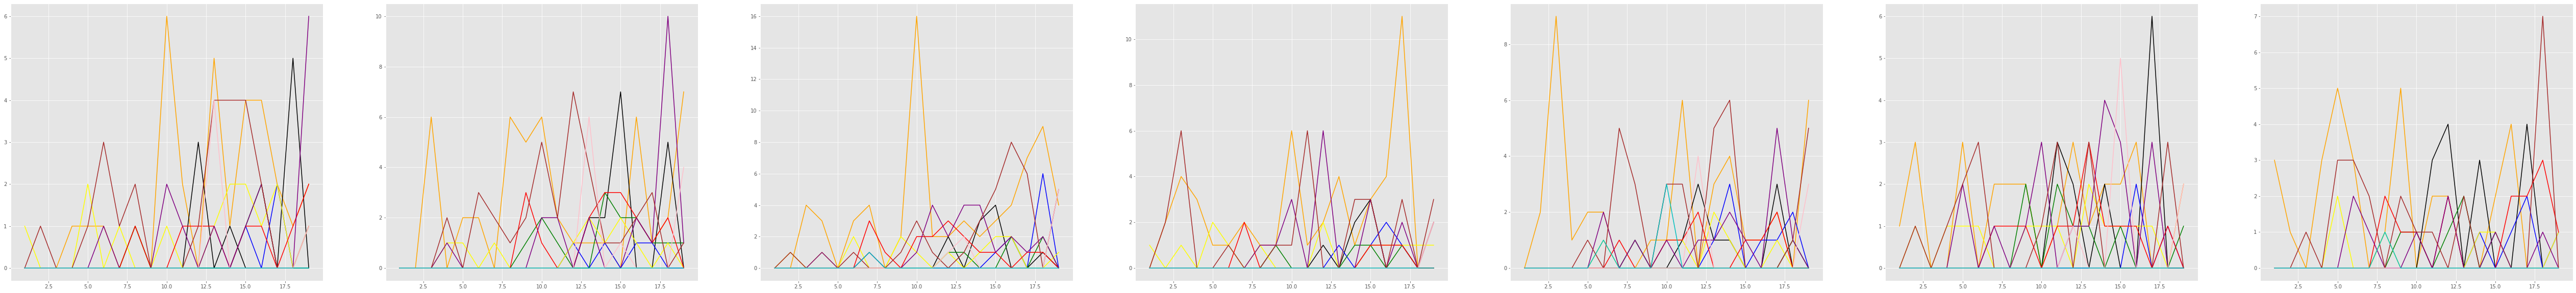

In [37]:


# fig, axs = plt.subplots(2, 7, sharex=True, sharey=True)
fig = plt.figure(figsize=(90, 10))

week2number = {'Friday': 0, 'Saturday': 1, 'Sunday': 2, 'Monday': 3, 'Tuesday': 4, 'Wednesday': 5, 'Thursday': 6}
product2color = {71165: 'orange', 71170: 'black', 71185: 'blue', 71215: 'green', 71220: 'yellow', 71225: 'red', 71230: 'purple', 71235: 'brown', 71285: 'pink', 71350: 'c'}
title_x = []
flag_print = True
for i in range(1, 20):
    title_x.append(i)

for i in first_warehouse.items():
    for j in i[1].items():
        position = 171 + week2number[j[0]]
        ax = fig.add_subplot(position)
        ax.plot(title_x, j[1], color=product2color[i[0]])
        if flag_print:
            print(j[0])
    flag_print = False

'''
for i in second_warehouse.values():
    for j in i.items():
        position = 276 + week2number[j[0]]
        ax = fig.add_subplot(position)
        ax.plot(title_x, j[1], color='orange', label=j[0])
'''
#fig = plt.figure(figsize=(cm_to_inch(15),cm_to_inch(10)))
#plt.tight_layout()
plt.show()


### Исходя из графиков можно сделать выводы:

*   Имеется **тенденция роста**. Скорее всего это связано с тем, что чем дольше существует магазин, тем больше покупателей в него ходит. Поэтому экспоненциальное сглаживание дало небольшой прирост.
*   Есть ярко выраженные **выбросы**. Можно попробовать с ними побороться.
*   В **Saturday** люди закупаются занчительнее чаще, чем в остальные дни. Его в качестве соседнего дня лучше не использовать.
*   В **Sunday** и **Wednesday** люди покупают продукты подозрительно равномерно.

Все эти выводы сделаны на основе 10 первых продуктов из первого магазина. Поэтому на последний пункт закроем глаза. А вот с остальными пунктами можно поработать.




### Борьба с выбросами



In [38]:
data_ = pd.Series(pd.to_datetime(train_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(train_data['date'].unique(), data_week))
print(date2week)

{'2020-11-27': 'Friday', '2020-11-28': 'Saturday', '2020-11-29': 'Sunday', '2020-11-30': 'Monday', '2020-12-01': 'Tuesday', '2020-12-02': 'Wednesday', '2020-12-03': 'Thursday', '2020-12-04': 'Friday', '2020-12-05': 'Saturday', '2020-12-06': 'Sunday', '2020-12-07': 'Monday', '2020-12-08': 'Tuesday', '2020-12-09': 'Wednesday', '2020-12-10': 'Thursday', '2020-12-11': 'Friday', '2020-12-12': 'Saturday', '2020-12-13': 'Sunday', '2020-12-14': 'Monday', '2020-12-15': 'Tuesday', '2020-12-16': 'Wednesday', '2020-12-17': 'Thursday', '2020-12-18': 'Friday', '2020-12-19': 'Saturday', '2020-12-20': 'Sunday', '2020-12-21': 'Monday', '2020-12-22': 'Tuesday', '2020-12-23': 'Wednesday', '2020-12-24': 'Thursday', '2020-12-25': 'Friday', '2020-12-26': 'Saturday', '2020-12-27': 'Sunday', '2020-12-28': 'Monday', '2020-12-29': 'Tuesday', '2020-12-30': 'Wednesday', '2020-12-31': 'Thursday', '2021-01-01': 'Friday', '2021-01-02': 'Saturday', '2021-01-03': 'Sunday', '2021-01-04': 'Monday', '2021-01-05': 'Tuesda

In [39]:
right_answer = []
answer_round, answer_floor, answer_ceil = [], [], []
answer_median, answer_median_low, answer_median_high = [], [], []
answer_mode, answer_exp = [], []
threshold  = 8
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
            local_max = 0
            local_i = 0
            for i in range(len(data)):
                if local_max < data[i]:
                    local_max = data[i]
                    local_i = i

            data[local_i] = data[-1]  # Удаление максимального элемента
            data.pop()


            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            answer_round.append(round(sum(data)/len(data)))
            answer_floor.append(math.floor(sum(data)/len(data)))
            answer_ceil.append(math.ceil(sum(data)/len(data)))

            answer_median.append(statistics.median(data))
            answer_median_low.append(statistics.median_low(data))
            answer_median_high.append(statistics.median_high(data))
            
            answer_exp.append(math.floor(exponential_smoothing(data, 0.14)))
            #answer_mode.append(int(s.mode(data)[0]))

print(mean_absolute_error(right_answer, answer_round))
print(mean_absolute_error(right_answer, answer_floor))
print(mean_absolute_error(right_answer, answer_ceil))

print(mean_absolute_error(right_answer, answer_median))
print(mean_absolute_error(right_answer, answer_median_low))
print(mean_absolute_error(right_answer, answer_median_high))

print(mean_absolute_error(right_answer, answer_exp))
#print(mean_absolute_error(right_answer, answer_mode))

100%|██████████| 3288/3288 [00:06<00:00, 526.00it/s]


0.20205509210983663
0.19760166840458812
0.3973974626346889
0.19797097671185263
0.19797097671185263
0.19797097671185263
0.19653719151894333


### Пока это лучший результат. Помогло самое обычное удаление максимума.

### Итак, теперь попробуем разбить дни на пары и пытаться делать выводы:

*   Суббота отдельно, как говорил выше
*   Пятница - воскресенье, как выходные дни
*   Понедельник - вторник
*   Среда - чтеверг

Зададим коэффициент, который будет понижать важность второго дня, ибо брать чисто среднее не очень круто




In [40]:
cur_min = 1
best_alpha = 0
best_beta = 0
for alpha in tqdm(range(1, 12)):
    for beta in range(1, 11):
        if beta <= alpha:
            right_answer = []
            answer_exp = []
            for id_warehouse in warehouse_id:
                for id_product in (product_id):
                    for id_date in date:
                        '''
                        Friday
                        Saturday
                        Sunday
                        Monday
                        Tuesday
                        Wednesday
                        Thursday
                        '''
                        data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
                        local_max = 0
                        local_i = 0
                        for i in range(len(data)):
                            if local_max < data[i]:
                                local_max = data[i]
                                local_i = i

                        data[local_i] = data[-1]  # Удаление максимального элемента
                        data.pop()
                        right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
                        my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

                        if date2week[id_date] == 'Saturday':
                            answer_exp.append(my_ans_by_day)
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Friday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        elif date2week[id_date] == 'Sunday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Monday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
                        
                        elif date2week[id_date] == 'Tuesday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Wednesday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
                        
                        elif date2week[id_date] == 'Thursday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))

            if mean_absolute_error(right_answer, answer_exp) < cur_min:
                best_alpha = alpha
                best_beta = beta
                cur_min = mean_absolute_error(right_answer, answer_exp)
print()
print(cur_min, best_alpha, best_beta)
            #print(mean_absolute_error(right_answer, answer_mode))

 64%|██████▎   | 7/11 [05:39<03:58, 59.62s/it]

KeyboardInterrupt: ignored

### Мда... Ну окей давайте зальём с таким выводом

In [ ]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))


#print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

In [ ]:
answer = []
alpha = 0.14
alpha = 1
beta = 1
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = (product_info[2])

    data = my_huge_dict[id_warehouse][id_product][date2week[id_date]].copy()
    local_max = 0
    local_i = 0
    for i in range(len(data)):
        if local_max < data[i]:
            local_max = data[i]
            local_i = i

    data[local_i] = data[-1]  # Удаление максимального элемента
    data.pop()
    #right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
    my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

    if date2week[id_date] == 'Saturday':
        answer.append(my_ans_by_day)
    
    #-----------------------------------
    elif date2week[id_date] == 'Friday':
        data2 = my_huge_dict[id_warehouse][id_product]['Sunday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
    elif date2week[id_date] == 'Sunday':
        data2 = my_huge_dict[id_warehouse][id_product]['Friday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
    #-----------------------------------
    elif date2week[id_date] == 'Monday':
        data2 = my_huge_dict[id_warehouse][id_product]['Tuesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
    elif date2week[id_date] == 'Tuesday':
        data2 = my_huge_dict[id_warehouse][id_product]['Monday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
    #-----------------------------------
    elif date2week[id_date] == 'Wednesday':
        data2 = my_huge_dict[id_warehouse][id_product]['Thursday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
    elif date2week[id_date] == 'Thursday':
        data2 = my_huge_dict[id_warehouse][id_product]['Wednesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta))
    
print()
print(len(answer), len(simple_data))

In [ ]:
#Result_table = pd.read_csv("/content/drive/MyDrive/Sales_Forecasting/sub.csv")
#Result_table['quantity'] = pd.Series(answer)
#Result_table[["id", "quantity"]].to_csv("FINAL_3.csv", index=False)

### Score = 0.20137
### Хуже чем прошлая попытка... Явно есть ошибка

### Забыл округлить... Давайте перебеём параметры заново.

In [ ]:
cur_min = 1
best_alpha = 0
best_beta = 0
for alpha in tqdm(range(1, 7)):
    for beta in range(1, 7):
        if beta <= alpha:
            right_answer = []
            answer_exp = []
            for id_warehouse in warehouse_id:
                for id_product in (product_id):
                    for id_date in date:
                        '''
                        Friday
                        Saturday
                        Sunday
                        Monday
                        Tuesday
                        Wednesday
                        Thursday
                        '''
                        data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
                        local_max = 0
                        local_i = 0
                        for i in range(len(data)):
                            if local_max < data[i]:
                                local_max = data[i]
                                local_i = i

                        data[local_i] = data[-1]  # Удаление максимального элемента
                        data.pop()
                        right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
                        my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

                        if date2week[id_date] == 'Saturday':
                            answer_exp.append(my_ans_by_day)
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Friday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        elif date2week[id_date] == 'Sunday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Monday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        elif date2week[id_date] == 'Tuesday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        #-----------------------------------
                        elif date2week[id_date] == 'Wednesday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                        
                        elif date2week[id_date] == 'Thursday':
                            data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                            my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                            answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

            if mean_absolute_error(right_answer, answer_exp) < cur_min:
                best_alpha = alpha
                best_beta = beta
                cur_min = mean_absolute_error(right_answer, answer_exp)
print()
print(cur_min, best_alpha, best_beta)

In [ ]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))


#print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

In [ ]:
answer = []
alpha = 0.14
alpha = 1
beta = 1
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = (product_info[2])

    data = my_huge_dict[id_warehouse][id_product][date2week[id_date]].copy()
    local_max = 0
    local_i = 0
    for i in range(len(data)):
        if local_max < data[i]:
            local_max = data[i]
            local_i = i

    data[local_i] = data[-1]  # Удаление максимального элемента
    data.pop()
    #right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
    my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

    if date2week[id_date] == 'Saturday':
        answer.append(my_ans_by_day)
    
    #-----------------------------------
    elif date2week[id_date] == 'Friday':
        data2 = my_huge_dict[id_warehouse][id_product]['Sunday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Sunday':
        data2 = my_huge_dict[id_warehouse][id_product]['Friday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    #-----------------------------------
    elif date2week[id_date] == 'Monday':
        data2 = my_huge_dict[id_warehouse][id_product]['Tuesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Tuesday':
        data2 = my_huge_dict[id_warehouse][id_product]['Monday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    #-----------------------------------
    elif date2week[id_date] == 'Wednesday':
        data2 = my_huge_dict[id_warehouse][id_product]['Thursday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Thursday':
        data2 = my_huge_dict[id_warehouse][id_product]['Wednesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
print()
print(len(answer), len(simple_data))

In [ ]:
Result_table = pd.read_csv("../input/grocery-sales-forecast/sub.csv")
Result_table['quantity'] = pd.Series(answer)
Result_table[["id", "quantity"]].to_csv("FINAL_33.csv", index=False)

### Score = 0.19921
### Потянет

## Финальная попытка усовершенствовать результат


### Пробуем 2 идеи:

*   Аккуратнее обрабатывать выбросы
*   Попробовать другую группировку дней



In [41]:
data_ = pd.Series(pd.to_datetime(train_data['date'].unique()))

# print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(train_data['date'].unique(), data_week))
print(date2week)

{'2020-11-27': 'Friday', '2020-11-28': 'Saturday', '2020-11-29': 'Sunday', '2020-11-30': 'Monday', '2020-12-01': 'Tuesday', '2020-12-02': 'Wednesday', '2020-12-03': 'Thursday', '2020-12-04': 'Friday', '2020-12-05': 'Saturday', '2020-12-06': 'Sunday', '2020-12-07': 'Monday', '2020-12-08': 'Tuesday', '2020-12-09': 'Wednesday', '2020-12-10': 'Thursday', '2020-12-11': 'Friday', '2020-12-12': 'Saturday', '2020-12-13': 'Sunday', '2020-12-14': 'Monday', '2020-12-15': 'Tuesday', '2020-12-16': 'Wednesday', '2020-12-17': 'Thursday', '2020-12-18': 'Friday', '2020-12-19': 'Saturday', '2020-12-20': 'Sunday', '2020-12-21': 'Monday', '2020-12-22': 'Tuesday', '2020-12-23': 'Wednesday', '2020-12-24': 'Thursday', '2020-12-25': 'Friday', '2020-12-26': 'Saturday', '2020-12-27': 'Sunday', '2020-12-28': 'Monday', '2020-12-29': 'Tuesday', '2020-12-30': 'Wednesday', '2020-12-31': 'Thursday', '2021-01-01': 'Friday', '2021-01-02': 'Saturday', '2021-01-03': 'Sunday', '2021-01-04': 'Monday', '2021-01-05': 'Tuesda

In [ ]:
right_answer = []
answer_round, answer_floor, answer_ceil = [], [], []
answer_median, answer_median_low, answer_median_high = [], [], []
answer_mode, answer_exp = [], []
threshold  = 1.5
for id_warehouse in warehouse_id:
    for id_product in tqdm(product_id):
        for id_date in date:
            data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
            local_max = 0
            local_i = 0
            for i in range(len(data)):
                if local_max < data[i]:
                    local_max = data[i]
                    local_i = i
            
            if local_max > threshold * math.floor(sum(data)/len(data)):
                data[local_i] = data[-1]  # Удаление максимального элемента
                data.pop()
            else:
                data[local_i] = data[-1]  # Удаление максимального элемента
                data.pop()


            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            answer_round.append(round(sum(data)/len(data)))
            answer_floor.append(math.floor(sum(data)/len(data)))
            answer_ceil.append(math.ceil(sum(data)/len(data)))

            answer_median.append(statistics.median(data))
            answer_median_low.append(statistics.median_low(data))
            answer_median_high.append(statistics.median_high(data))
            
            answer_exp.append(math.floor(exponential_smoothing(data, 0.14)))
            #answer_mode.append(int(s.mode(data)[0]))

print(mean_absolute_error(right_answer, answer_round))
print(mean_absolute_error(right_answer, answer_floor))
print(mean_absolute_error(right_answer, answer_ceil))

print(mean_absolute_error(right_answer, answer_median))
print(mean_absolute_error(right_answer, answer_median_low))
print(mean_absolute_error(right_answer, answer_median_high))

print(mean_absolute_error(right_answer, answer_exp))
#print(mean_absolute_error(right_answer, answer_mode))



  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:12<03:52, 12.94s/it]

 11%|█         | 2/19 [00:25<03:39, 12.93s/it]

 16%|█▌        | 3/19 [00:38<03:26, 12.90s/it]

 21%|██        | 4/19 [00:51<03:14, 12.94s/it]

 26%|██▋       | 5/19 [01:04<03:00, 12.88s/it]

 32%|███▏      | 6/19 [01:17<02:46, 12.85s/it]

 37%|███▋      | 7/19 [01:29<02:33, 12.81s/it]

 42%|████▏     | 8/19 [01:42<02:20, 12.79s/it]

 47%|████▋     | 9/19 [01:55<02:08, 12.85s/it]

 53%|█████▎    | 10/19 [02:08<01:55, 12.83s/it]

 58%|█████▊    | 11/19 [02:21<01:42, 12.81s/it]

 63%|██████▎   | 12/19 [02:33<01:29, 12.79s/it]

 68%|██████▊   | 13/19 [02:46<01:16, 12.80s/it]

 74%|███████▎  | 14/19 [02:59<01:03, 12.79s/it]

 79%|███████▉  | 15/19 [03:12<00:51, 12.78s/it]

 84%|████████▍ | 16/19 [03:25<00:38, 12.79s/it]

 89%|████████▉ | 17/19 [03:37<00:25, 12.79s/it]

 95%|█████████▍| 18/19 [03:50<00:12, 12.80s/it]

100%|██████████| 19/19 [04:03<00:00, 12.82s/it]



0.19406065345846368 5.5


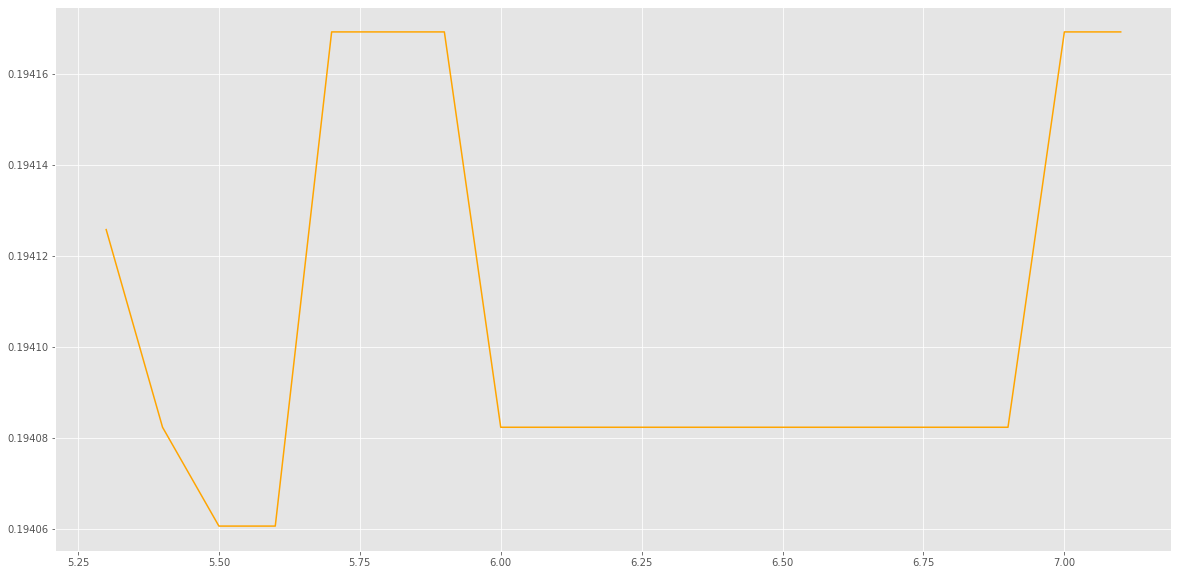

In [53]:
cur_min = 1
alpha = 1
beta = 1
best_threshold = 1
A, B = [], []
for koef in tqdm(range(53, 72)):
    threshold = koef/10
    right_answer = []
    answer_exp = []
    for id_warehouse in warehouse_id:
        for id_product in (product_id):
            for id_date in date:
                data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
                local_max = 0
                local_i = 0
                for i in range(len(data)):
                    if local_max < data[i]:
                        local_max = data[i]
                        local_i = i

                if local_max > threshold * math.floor(sum(data)/len(data)):
                    data[local_i] = data[-1]  # Удаление максимального элемента
                    data.pop()

                right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
                my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

                if date2week[id_date] == 'Saturday':
                    answer_exp.append(my_ans_by_day)
                
                #-----------------------------------
                elif date2week[id_date] == 'Friday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                
                elif date2week[id_date] == 'Sunday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                
                #-----------------------------------
                elif date2week[id_date] == 'Monday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                
                elif date2week[id_date] == 'Tuesday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                
                #-----------------------------------
                elif date2week[id_date] == 'Wednesday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
                
                elif date2week[id_date] == 'Thursday':
                    data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                    my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                    answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

    if mean_absolute_error(right_answer, answer_exp) < cur_min:
        best_threshold = threshold
        cur_min = mean_absolute_error(right_answer, answer_exp)
    
    A.append(mean_absolute_error(right_answer, answer_exp))
    B.append(threshold)
print()
print(cur_min, best_threshold)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(B, A, color='orange')
plt.show()

### Окей, это пока лучший результат. Оставим threshold = 5.5

### Попробуем сгруппировать другим образом:

*   Сб, вс-пн, вт-ср, чт-пт
*   Для каждого дня будем учитывать предыдущий, минуя субботу
*   Для каждого дня будем учитывать предыдущий, включая субботу

Пока 0.19406065345846368 лучший скор на наших данных


In [55]:
cur_min = 1
alpha = 1
beta = 1
threshold = 5.5
right_answer = []
answer_exp = []
for id_warehouse in warehouse_id:
    for id_product in (product_id):
        for id_date in date:
            data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
            local_max = 0
            local_i = 0
            for i in range(len(data)):
                if local_max < data[i]:
                    local_max = data[i]
                    local_i = i

            if local_max > threshold * math.floor(sum(data)/len(data)):
                data[local_i] = data[-1]  # Удаление максимального элемента
                data.pop()

            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

            if date2week[id_date] == 'Saturday':
                answer_exp.append(my_ans_by_day)
            
            #-----------------------------------
            elif date2week[id_date] == 'Friday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Thursday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Monday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Sunday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Wednesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Tuesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

print()
print(mean_absolute_error(right_answer, answer_exp))



0.19410410149461244


In [56]:
cur_min = 1
alpha = 1
beta = 1
threshold = 5.5
right_answer = []
answer_exp = []
for id_warehouse in warehouse_id:
    for id_product in (product_id):
        for id_date in date:
            data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
            local_max = 0
            local_i = 0
            for i in range(len(data)):
                if local_max < data[i]:
                    local_max = data[i]
                    local_i = i

            if local_max > threshold * math.floor(sum(data)/len(data)):
                data[local_i] = data[-1]  # Удаление максимального элемента
                data.pop()

            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

            if date2week[id_date] == 'Saturday':
                answer_exp.append(my_ans_by_day)
            
            #-----------------------------------
            elif date2week[id_date] == 'Friday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Thursday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Monday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Sunday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Wednesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Tuesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

print()
print(mean_absolute_error(right_answer, answer_exp))



0.19393030935001737


In [57]:
cur_min = 1
alpha = 1
beta = 1
threshold = 5.5
right_answer = []
answer_exp = []
for id_warehouse in warehouse_id:
    for id_product in (product_id):
        for id_date in date:
            data = my_huge_dict_train[id_warehouse][id_product][date2week[id_date]].copy()
            local_max = 0
            local_i = 0
            for i in range(len(data)):
                if local_max < data[i]:
                    local_max = data[i]
                    local_i = i

            if local_max > threshold * math.floor(sum(data)/len(data)):
                data[local_i] = data[-1]  # Удаление максимального элемента
                data.pop()

            right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
            my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

            if date2week[id_date] == 'Saturday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Friday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Thursday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Monday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Sunday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Saturday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            #-----------------------------------
            elif date2week[id_date] == 'Wednesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
            
            elif date2week[id_date] == 'Tuesday':
                data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
                my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
                answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

print()
print(mean_absolute_error(right_answer, answer_exp))



0.19397375738616615


### Такс, ну субботу включать всё-таки не нужно, а вот идея с предыдущим днём стрельнула. На этом и остановлюсь, ибо тестировать группы по 3 дня это очень странная идея.

In [58]:
data_ = pd.Series(pd.to_datetime(test_data['date'].unique()))


#print(data_, type(data_))
data_week = data_.dt.day_name()
# print(data_week)
date2week = dict(zip(test_data['date'].unique(), data_week))
print(date2week)

{'2021-04-09': 'Friday', '2021-04-10': 'Saturday', '2021-04-11': 'Sunday', '2021-04-12': 'Monday', '2021-04-13': 'Tuesday', '2021-04-14': 'Wednesday', '2021-04-15': 'Thursday'}


In [59]:
cur_min = 1
alpha = 1
beta = 1
threshold = 5.5
right_answer = []
answer_exp = []
for product_info in tqdm(test_data[['warehouse_id', 'product_id', 'date']].values):
    id_warehouse = (product_info[0])
    id_product = (product_info[1])
    id_date = (product_info[2])

    data = my_huge_dict[id_warehouse][id_product][date2week[id_date]].copy()
    local_max = 0
    local_i = 0
    for i in range(len(data)):
        if local_max < data[i]:
            local_max = data[i]
            local_i = i

    if local_max > threshold * math.floor(sum(data)/len(data)):
        data[local_i] = data[-1]  # Удаление максимального элемента
        data.pop()

    # right_answer.append(my_huge_dict_test[id_warehouse][id_product][date2week[id_date]][0])
    my_ans_by_day = math.floor(exponential_smoothing(data, 0.14))

    if date2week[id_date] == 'Saturday':
        answer_exp.append(my_ans_by_day)
    
    #-----------------------------------
    elif date2week[id_date] == 'Friday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Thursday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Thursday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Wednesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    #-----------------------------------
    elif date2week[id_date] == 'Monday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Sunday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Sunday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Friday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    #-----------------------------------
    elif date2week[id_date] == 'Wednesday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Tuesday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))
    
    elif date2week[id_date] == 'Tuesday':
        data2 = my_huge_dict_train[id_warehouse][id_product]['Monday'].copy()
        my_ans_by_second_day = math.floor(exponential_smoothing(data2, 0.14))
        answer_exp.append(math.floor((my_ans_by_day * alpha + my_ans_by_second_day * beta) / (alpha + beta)))

print()
# print(mean_absolute_error(right_answer, answer_exp))
print(len(answer_exp), len(simple_data))



  0%|          | 0/46032 [00:00<?, ?it/s]

  8%|▊         | 3528/46032 [00:00<00:01, 35275.83it/s]

 19%|█▉        | 8644/46032 [00:00<00:00, 38898.86it/s]

 32%|███▏      | 14898/46032 [00:00<00:00, 43873.61it/s]

 41%|████      | 18942/46032 [00:00<00:00, 42782.64it/s]

 51%|█████▏    | 23592/46032 [00:00<00:00, 43833.86it/s]

 61%|██████    | 28160/46032 [00:00<00:00, 44370.56it/s]

 71%|███████   | 32453/46032 [00:00<00:00, 43925.78it/s]

 80%|███████▉  | 36751/46032 [00:00<00:00, 43635.69it/s]

 90%|████████▉ | 41218/46032 [00:00<00:00, 43939.08it/s]

100%|██████████| 46032/46032 [00:01<00:00, 44445.36it/s]


46032 46032


In [60]:
#Result_table = pd.read_csv("/content/drive/MyDrive/Sales_Forecasting/sub.csv")
#Result_table['quantity'] = pd.Series(answer_exp)
#Result_table[["id", "quantity"]].to_csv("Last_try.csv", index=False)

### Score = 0.19935
### Хуже, чем прошлая попытка. Грустно. Но ничего нового я уже пробовать не буду, ибо попыток не осталось.